In [1]:
import keras
from backtest import *
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Flatten, Permute, Reshape
from keras.layers import Input, concatenate, GaussianNoise
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers import Convolution1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, RepeatVector, AveragePooling1D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *
from keras.constraints import *
from keras import regularizers
from keras import losses

from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef

Using TensorFlow backend.


In [2]:
symbol = 'AMZ'
bars = pd.read_csv('./data/%s.csv' % symbol, header=0, parse_dates=['Date'])

In [3]:
print(bars)

      Unnamed: 0         Open       Date         High          Low  \
0              0   219.410004 2012-05-18   212.809998   219.630005   
1              1   214.029999 2012-05-21   212.820007   219.979996   
2              2   218.309998 2012-05-22   213.960007   218.869995   
3              3   214.710007 2012-05-23   211.179993   217.550003   
4              4   216.979996 2012-05-24   212.699997   217.660004   
5              5   214.990006 2012-05-25   212.220001   215.979996   
6              6   214.300003 2012-05-29   212.289993   216.550003   
7              7   212.139999 2012-05-30   207.750000   212.979996   
8              8   209.479996 2012-05-31   207.110001   213.789993   
9              9   208.440002 2012-06-01   207.300003   211.229996   
10            10   207.399994 2012-06-04   206.369995   215.350006   
11            11   213.850006 2012-06-05   211.160004   216.860001   
12            12   214.630005 2012-06-06   214.520004   218.399994   
13            13   2

In [4]:
START_TRAIN_DATE = '2012-05-18'
END_TRAIN_DATE = '2018-06-27'
START_TEST_DATE = '2018-06-28'
END_TEST_DATE = '2020-01-09'
LOOKBACK = 7
STEP = 1
FORECAST = 1
INIT_CAPITAL = 10000
STAKE = 10

In [5]:
train_set = bars[(bars['Date'] > START_TRAIN_DATE) & (bars['Date'] < END_TRAIN_DATE)]

In [6]:
test_set = bars[(bars['Date'] > START_TEST_DATE) & (bars['Date'] < END_TEST_DATE)]

In [7]:
def create_dataset(data):
    
    highp = pd.to_numeric(data.ix[:, 'High'])
    lowp = pd.to_numeric(data.ix[:, 'Low'])
    openp = pd.to_numeric(data.ix[:, 'Open'])
    closep = pd.to_numeric(data.ix[:, 'Close'])
    volumep = pd.to_numeric(data.ix[:, 'Volume'])

    normal_close = closep.values.tolist()
    normal_open = openp.values.tolist()

    highp = highp.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    lowp = lowp.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    openp = openp.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    closep = closep.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()
    volumep = volumep.pct_change().replace(np.nan, 0).replace(np.inf, 0).values.tolist()

    X, Y = [], []
    
    for i in range(0, len(data), STEP): 
        try:
            o = openp[i:i+LOOKBACK]
            h = highp[i:i+LOOKBACK]
            l = lowp[i:i+LOOKBACK]
            c = closep[i:i+LOOKBACK]
            v = volumep[i:i+LOOKBACK]
           
            y_i = (normal_close[i+LOOKBACK+FORECAST] - normal_open[i+LOOKBACK]) / normal_open[i+LOOKBACK]
            y_i = 1 if y_i > 0 else 0
            
            x_i = np.column_stack((o, h, l, c, v))
    
        except Exception as e:
            break

        X.append(x_i)
        Y.append(y_i)

    X, Y = np.array(X), np.array(Y)
    return X, Y

In [8]:
X_train, Y_train = create_dataset(train_set)
X_test, Y_test = create_dataset(test_set)

C:\Users\Pedro Takenouchi\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
def plot_history(history):
    plt.subplot(2, 1, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.axhline(y=0.5, color='grey', linestyle='--')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.axhline(y=0.693, color='grey', linestyle='--')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [10]:
def get_lr_model(x1, x2):
    main_input = Input(shape=(x1, x2, ), name='main_input')
    x = GaussianNoise(0.01)(main_input)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation = "sigmoid", name = "out")(x)
    final_model = Model(inputs=[main_input], outputs=[output])
    final_model.compile(optimizer=Adam(lr=0.001, amsgrad=True),  loss='binary_crossentropy', metrics = ['accuracy'])
    return final_model

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 7, 5)              0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 7, 5)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 35)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 35)                140       
_________________________________________________________________
dropout_1 (Dropout)          (None, 35)                0         
_________________________________________________________________
out (Dense)                  (None, 1)                 36        
Total params: 176
Trainable params: 106
Non-trainable params: 70
____________________________________________________________

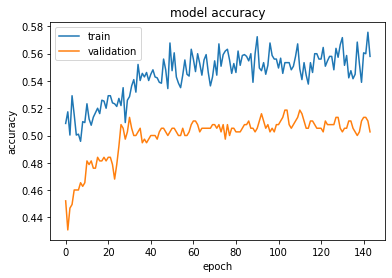

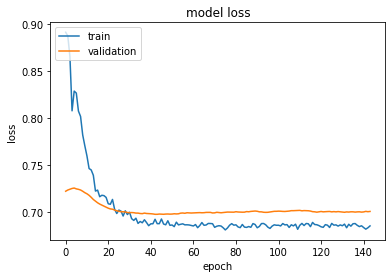

MATTHEWS CORRELATION
CONFUSION MATRIX
[[0.08196721 0.87046632]
 [0.1147541  0.89119171]]
CLASSIFICATION REPORT
--------------------


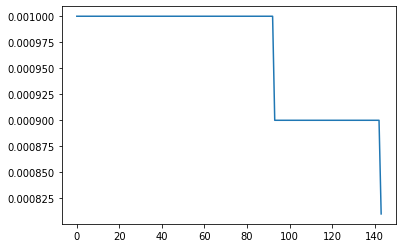

In [11]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=50, min_lr=0.000001, verbose=0)
checkpointer = ModelCheckpoint(filepath="testtest.hdf5", verbose=0, save_best_only=True)
es = EarlyStopping(patience=100)

model = get_lr_model(X_train.shape[1], X_train.shape[-1])
model.summary()

history = model.fit(X_train, Y_train, 
              epochs = 1000, 
              batch_size = 64, 
              verbose=0, 
              validation_data=(X_test, Y_test),
              callbacks=[reduce_lr, checkpointer, es],
              shuffle=True)

model.load_weights('testtest.hdf5')
pred = model.predict(X_test)

print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


#lr
plt.plot(history.history['lr'])

pred = [1 if p > 0.5 else 0 for p in pred]
C = confusion_matrix(Y_test, pred)

print ('MATTHEWS CORRELATION')
matthews_corrcoef(Y_test, pred)
print ('CONFUSION MATRIX')
print(C / C.astype(np.float).sum(axis=1))
print ('CLASSIFICATION REPORT')
classification_report(Y_test, pred)
print ('-' * 20)

In [12]:
pred = [1 if p == 1 else -1 for p in pred]
pred = [p if i % FORECAST == 0 else 0 for i, p in enumerate(pred)]
pred = [0.] * (LOOKBACK) + pred + [0] * FORECAST

In [13]:
class MachineLearningForecastingStrategy(Strategy):   
    
    def __init__(self, symbol, bars, pred):
        self.symbol = symbol
        self.bars = bars

    def generate_signals(self):
        signals = pd.DataFrame(index=self.bars.index)
        signals['signal'] = pred
        return signals

In [14]:
test_set['Close'] = test_set['Close'].shift(-FORECAST)

rfs = MachineLearningForecastingStrategy('LTC', test_set, pred)
signals = rfs.generate_signals()
portfolio = MarketIntradayPortfolio('LTC', test_set, signals, INIT_CAPITAL, STAKE)
returns = portfolio.backtest_portfolio()

C:\Users\Pedro Takenouchi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [15]:
returns['signal'] = signals
our_pct_growth = returns['total'].pct_change().cumsum()
benchmark_ptc_growth = test_set['Close'].pct_change().cumsum()

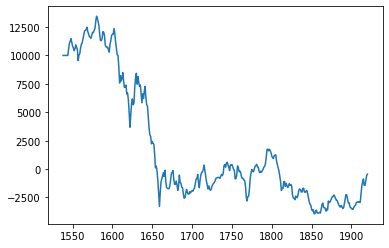

In [16]:
plt.figure()
plt.plot(returns['total'])
plt.show()

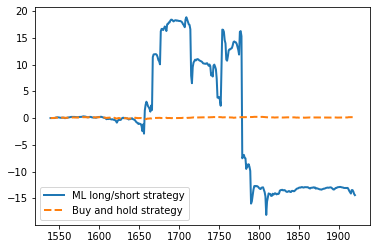

In [17]:
plt.figure()
plt.plot(our_pct_growth, label = 'ML long/short strategy', linewidth=2)
plt.plot(benchmark_ptc_growth, linestyle = '--', label = 'Buy and hold strategy', linewidth=2)
plt.legend()
plt.show()

In [18]:
def sharpe(returns):
    return np.sqrt(len(returns)) * returns.mean() / returns.std()

In [19]:
sharpe(our_pct_growth)

-1.7242623370310148

In [20]:
sharpe(benchmark_ptc_growth)

22.175485513988672

In [21]:
returns.tail()

,price_diff,profit,total,returns,signal
1917,-0.030029,-0.30029,-1425.89615,0.000211,1.0
1918,38.380005,383.80005,-1042.09610,-0.269164,1.0
1919,46.859985,468.59985,-573.49625,-0.449670,1.0
1920,-12.530029,125.30029,-448.19596,-0.218485,-1.0
1921,NaN,NaN,NaN,NaN,0.0
